In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
#plt.style.use('fivethirtyeight')
plt.rc('figure', figsize=(13, 7))

from datetime import datetime
from sklearn.metrics import mean_squared_error
from math import sqrt

from pandas.plotting import register_matplotlib_converters
from statsmodels.tsa.api import Holt

from acquire import get_store_data, opsd_germany_daily
import prepare

# 1. Split data (train/test) and resample by any period, except daily, and aggregate using the sum.

In [2]:
df = pd.read_csv('F.csv')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2015-10-28,14.78,15.00,14.67,14.97,11.841009,34485300
1,2015-10-29,14.94,14.96,14.61,14.73,11.651173,32247000
2,2015-10-30,14.74,14.95,14.63,14.81,11.714453,29225800
3,2015-11-02,14.79,14.90,14.71,14.75,11.666993,30295900
4,2015-11-03,14.78,14.87,14.72,14.81,11.714453,25878800


In [3]:
df.dtypes

Date          object
Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume         int64
dtype: object

In [4]:
df.Date = pd.to_datetime(df.Date)

df = df.set_index('Date').sort_index()

df=df.resample('W').mean()

df = df[['Close','Volume']]

df.head()

#df = pd.DataFrame(df.resample('M').Close.mean().ffill())

,Close,Volume
Date,,
2015-11-01,14.836667,3.198603e+07
2015-11-08,14.660000,2.586090e+07
2015-11-15,14.176000,2.202280e+07
2015-11-22,14.364000,2.331500e+07
2015-11-29,14.545000,1.497832e+07


In [5]:
df['Close'] = round(df.Close, 2)

In [6]:
df['Volume'] = df.Volume / 1000

In [7]:
df.resample('W').Close.mean().isna().sum()


0

In [8]:
train_size = int(len(df) * .5)
validate_size = int(len(df) * .3)
test_size = int(len(df) - train_size - validate_size)

validate_end_index = train_size + validate_size

In [9]:
train = df[: train_size]
validate = df[train_size:validate_end_index]
test = df[validate_end_index:]
train

,Close,Volume
Date,,
2015-11-01,14.84,31986.033333
2015-11-08,14.66,25860.900000
2015-11-15,14.18,22022.800000
2015-11-22,14.36,23315.000000
2015-11-29,14.55,14978.325000
...,...,...
2018-04-01,10.90,43782.625000
2018-04-08,11.17,38326.580000
2018-04-15,11.34,38863.700000


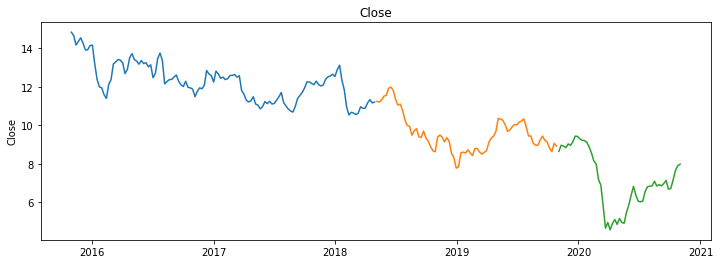

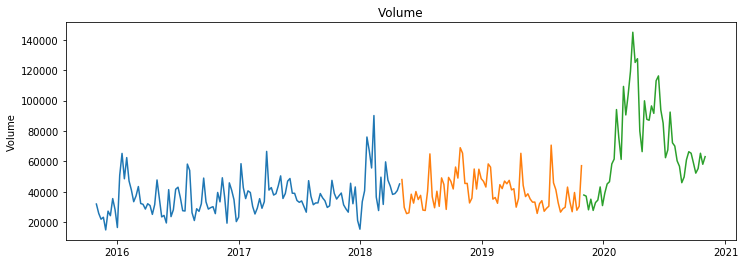

In [10]:
for col in train.columns:
    plt.figure(figsize=(12,4))
    plt.plot(train[col])
    plt.plot(validate[col])
    plt.plot(test[col])
    plt.ylabel(col)
    plt.title(col)
    plt.show()

In [11]:
def evaluate(target_var):
    rmse = round(sqrt(mean_squared_error(validate[target_var], yhat_df[target_var])), 0)
    return rmse


In [12]:
def plot_and_eval(target_var):
    plt.figure(figsize = (12,4))
    plt.plot(train[target_var], label='Train', linewidth=1)
    plt.plot(validate[target_var], label='Validate', linewidth=1)
    plt.plot(yhat_df[target_var])
    plt.title(target_var)
    rmse = evaluate(target_var)
    print(target_var, '-- RMSE: {:.0f}'.format(rmse))
    plt.show()

In [13]:
# create an empty dataframe
eval_df = pd.DataFrame(columns=['model_type', 'target_var', 'rmse'])

# function to store the rmse so that we can compare
def append_eval_df(model_type, target_var):
    rmse = evaluate(target_var)
    d = {'model_type': [model_type], 'target_var': [target_var],
        'rmse': [rmse]}
    d = pd.DataFrame(d)
    return eval_df.append(d, ignore_index = True)


# Last Observed Value

In [14]:
close = train['Close'][-1:][0] #Looking at just the last value
volume = round(train['Volume'][-1:][0],2) #Looking at just the last value

yhat_df = pd.DataFrame({'Close': [close], 'Volume': [volume]}, 
                       index = validate.index)

print(yhat_df.shape)
yhat_df.head(2)

(78, 2)


,Close,Volume
Date,,
2018-05-06,11.21,45194.06
2018-05-13,11.21,45194.06


Close -- RMSE: 2


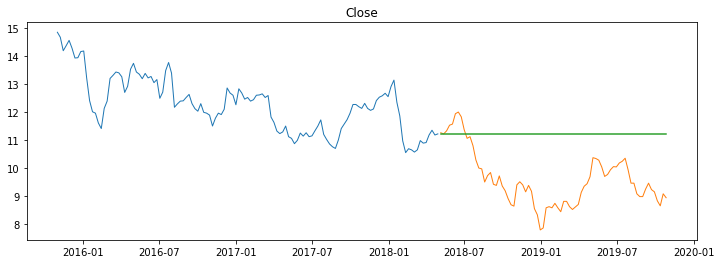

Volume -- RMSE: 11896


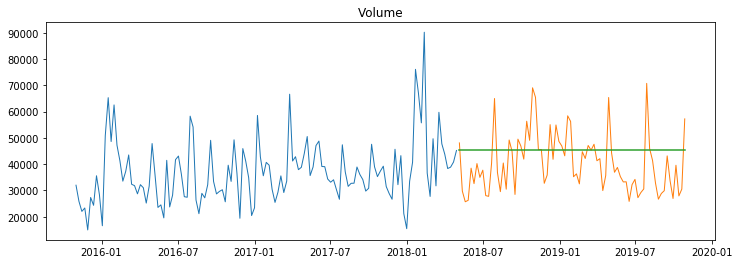

In [15]:
for col in train.columns:
    plot_and_eval(col)

### Evaluate


In [16]:
for col in train.columns:
    eval_df = append_eval_df(model_type='last_observed_value', 
                             target_var = col)
eval_df.head(2)

,model_type,target_var,rmse
0,last_observed_value,Close,2.0
1,last_observed_value,Volume,11896.0


# Simple Average

In [17]:
close = round(train['Close'].mean(), 2)
volume = round(train['Volume'].mean(), 2)

def make_predictions():
    yhat_df = pd.DataFrame({'Close': [close],
                            'Volume': [volume],
                           }, index = validate.index)
    return yhat_df

yhat_df = make_predictions()

In [18]:
yhat_df.head(2)

,Close,Volume
Date,,
2018-05-06,12.25,37017.12
2018-05-13,12.25,37017.12


Close -- RMSE: 3


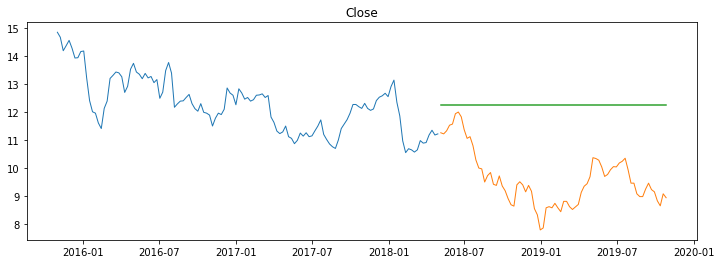

Volume -- RMSE: 11470


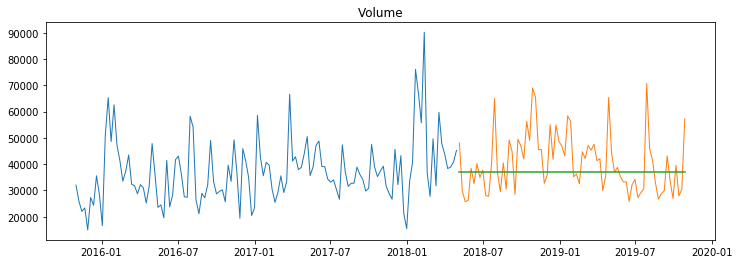

In [19]:
for col in train.columns:
    plot_and_eval(col)

### Evaluate

In [20]:
for col in train.columns:
    eval_df = append_eval_df(model_type='simple_average', 
                             target_var = col)

In [21]:
eval_df

,model_type,target_var,rmse
0,last_observed_value,Close,2.0
1,last_observed_value,Volume,11896.0
2,simple_average,Close,3.0
3,simple_average,Volume,11470.0


# Moving Average

In [22]:
train['Close'].rolling(4).mean() 

Date
2015-11-01        NaN
2015-11-08        NaN
2015-11-15        NaN
2015-11-22    14.5100
2015-11-29    14.4375
               ...   
2018-04-01    10.8475
2018-04-08    10.9800
2018-04-15    11.0725
2018-04-22    11.1450
2018-04-29    11.2225
Freq: W-SUN, Name: Close, Length: 131, dtype: float64

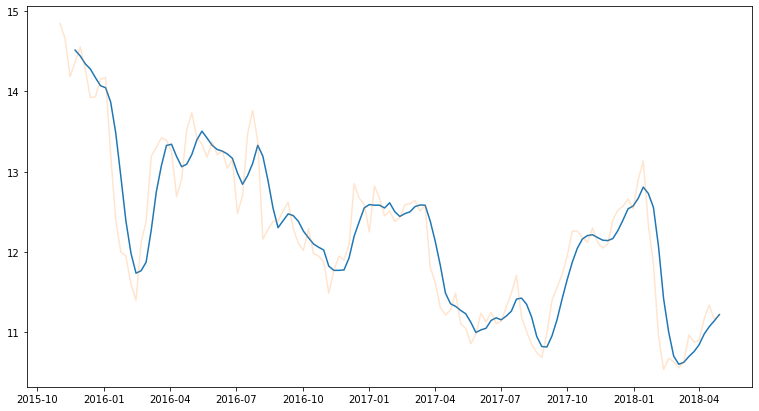

In [23]:
plt.plot(train['Close'].rolling(4).mean())
plt.plot(train['Close'], alpha = .2)

In [24]:
# Keeping it Kosher

print(train['Close'].head(4).mean()) 
print(train['Close'].rolling(4).mean()[3]) 

14.51
14.51


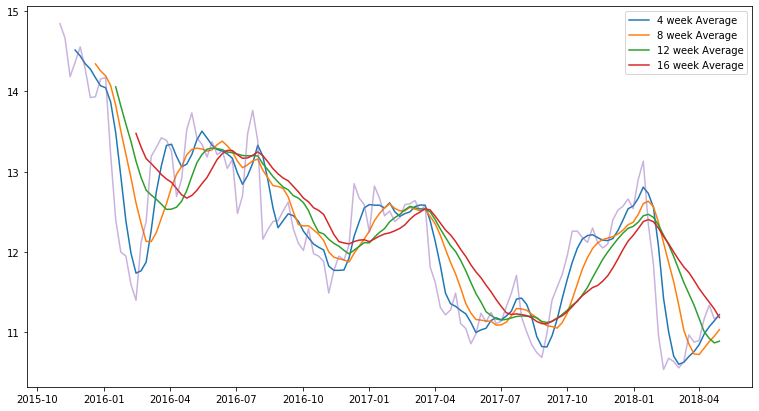

In [25]:
plt.figure(figsize=(13,7))
plt.plot(train['Close'].rolling(4).mean(), label = '4 week Average')
plt.plot(train['Close'].rolling(8).mean(), label = '8 week Average')
plt.plot(train['Close'].rolling(12).mean(), label = '12 week Average')
plt.plot(train['Close'].rolling(16).mean(), label = '16 week Average')
plt.plot(train['Close'], alpha = .5)
plt.legend()

### Make some predictions

In [26]:
period = 4

close = round(train['Close'].rolling(period).mean()[-1], 2)
close

11.22

In [27]:
volume = round(train['Volume'].rolling(period).mean()[-1], 2)
volume

40797.1

In [28]:
yhat_df = make_predictions()
yhat_df.head()

,Close,Volume
Date,,
2018-05-06,11.22,40797.1
2018-05-13,11.22,40797.1
2018-05-20,11.22,40797.1
2018-05-27,11.22,40797.1
2018-06-03,11.22,40797.1


Close -- RMSE: 2


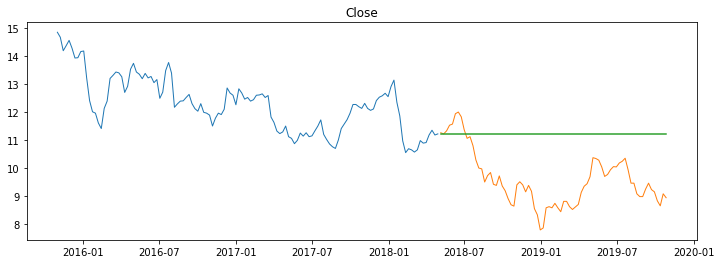

Volume -- RMSE: 10934


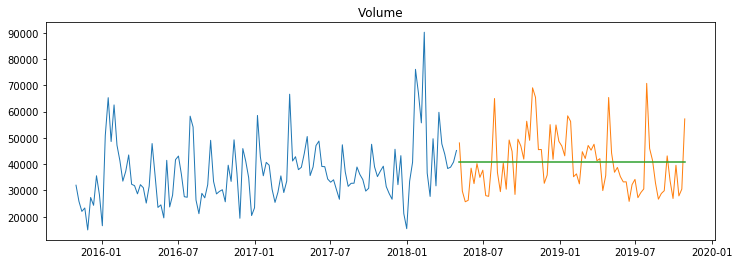

In [29]:
for col in train.columns:
    plot_and_eval(col)

### Evaluate

In [30]:
for col in train.columns:
    eval_df = append_eval_df(model_type = '4W_moving_avg', target_var = col)
    
eval_df


,model_type,target_var,rmse
0,last_observed_value,Close,2.0
1,last_observed_value,Volume,11896.0
2,simple_average,Close,3.0
3,simple_average,Volume,11470.0
4,4W_moving_avg,Close,2.0
5,4W_moving_avg,Volume,10934.0


In [31]:
periods = [1, 4, 8, 12, 16, 24]

for p in periods:
    close = round(train['Close'].rolling(p).mean().iloc[-1], 2)
    volume = round(train['Volume'].rolling(p).mean().iloc[-1], 2)
    yhat_df = make_predictions()
    model_type = str(p) + 'W moving average'
    eval_df = append_eval_df(model_type = model_type,
                             target_var = 'Close'
                            )
    eval_df = append_eval_df(model_type = model_type,
                             target_var = 'Volume'
                            )

In [32]:
eval_df

,model_type,target_var,rmse
0,last_observed_value,Close,2.0
1,last_observed_value,Volume,11896.0
2,simple_average,Close,3.0
3,simple_average,Volume,11470.0
4,4W_moving_avg,Close,2.0
5,4W_moving_avg,Volume,10934.0
6,1W moving average,Close,2.0
7,1W moving average,Volume,11896.0
8,4W moving average,Close,2.0
9,4W moving average,Volume,10934.0


In [33]:
eval_df.sort_values(by='rmse', ascending = True).head(1)


,model_type,target_var,rmse
0,last_observed_value,Close,2.0


# Holts Linear Trend

### Season Decomposition

Close 



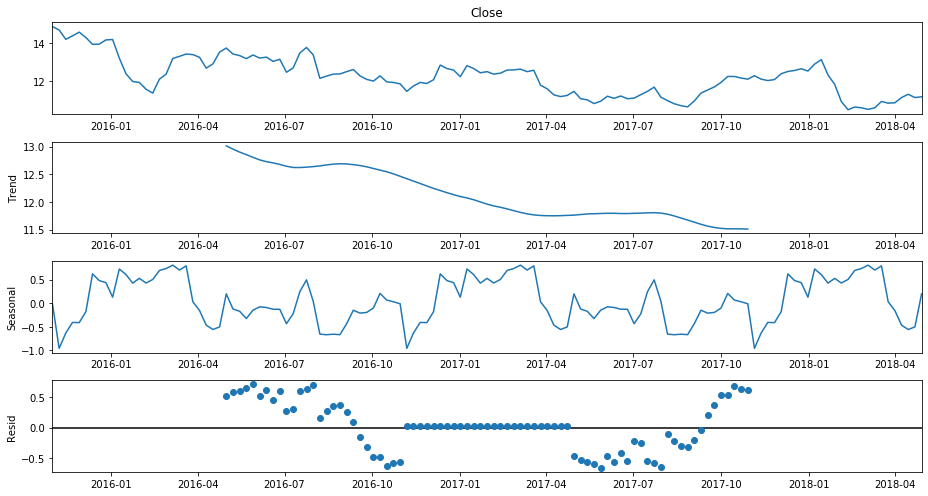

Volume 



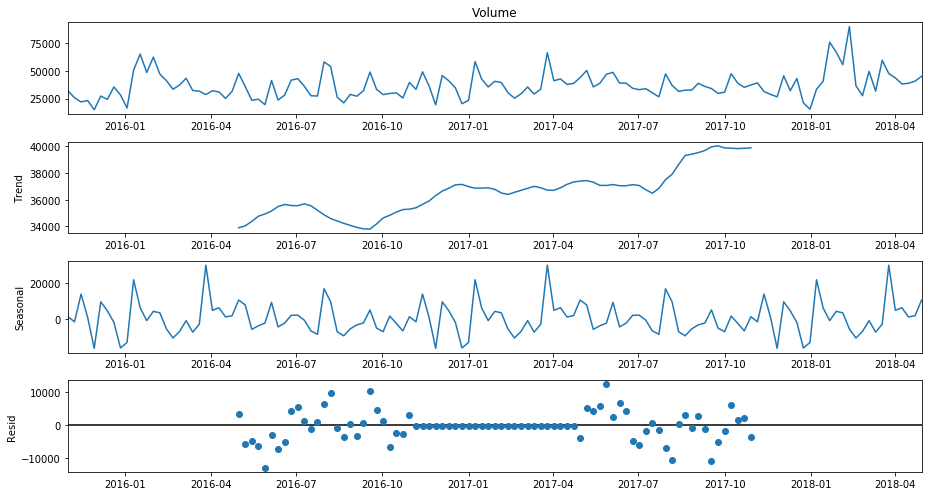

In [34]:
for col in train.columns:
    print(col, '\n')
    sm.tsa.seasonal_decompose(train[col].resample('W').mean()).plot()
    plt.show()

### Predictions

In [37]:

for col in train.columns:
    model = Holt(train.resample('W')[col].mean(), exponential = False, damped=True)
    model = model.fit(smoothing_level = .5, 
                      smoothing_slope = .4, 
                      optimized = True)
    yhat_items = model.predict(start = validate.index[0], 
                               end = validate.index[-1])
    yhat_df[col] = round(yhat_items, 2)

In [38]:
yhat_df.head()

,Close,Volume
Date,,
2018-05-06,11.23,42933.7
2018-05-13,11.24,42933.7
2018-05-20,11.24,42933.7
2018-05-27,11.24,42933.7
2018-06-03,11.25,42933.7


In [ ]:
#df.resample('D').Volume.mean().head(30)

In [ ]:
#df.resample('D').Volume.mean().ffill()

In [ ]:
#df.resample

Close -- RMSE: 2


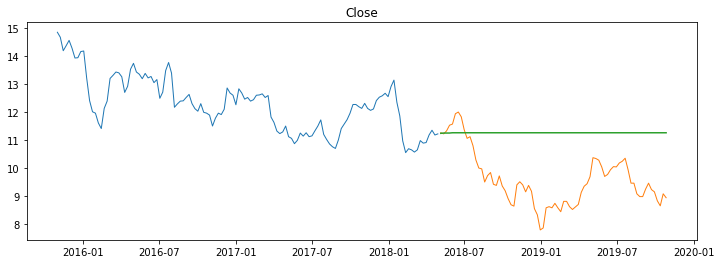

Volume -- RMSE: 11198


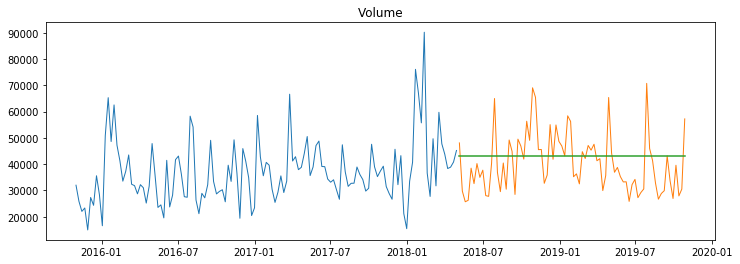

In [39]:
for col in train.columns:
    plot_and_eval(target_var = col)

### Evaluate

In [40]:
for col in train.columns:
    eval_df = append_eval_df(model_type = 'holts_optimized', 
                            target_var = col)

In [41]:
eval_df.sort_values(by='rmse')

,model_type,target_var,rmse
0,last_observed_value,Close,2.0
16,24W moving average,Close,2.0
14,16W moving average,Close,2.0
4,4W_moving_avg,Close,2.0
12,12W moving average,Close,2.0
6,1W moving average,Close,2.0
10,8W moving average,Close,2.0
8,4W moving average,Close,2.0
18,holts_optimized,Close,2.0
2,simple_average,Close,3.0


# Predict based on previous cycle

### Gotta re-split the data

In [42]:
df

,Close,Volume
Date,,
2015-11-01,14.84,31986.033333
2015-11-08,14.66,25860.900000
2015-11-15,14.18,22022.800000
2015-11-22,14.36,23315.000000
2015-11-29,14.55,14978.325000
...,...,...
2020-10-04,6.72,52303.680000
2020-10-11,7.17,55343.700000
2020-10-18,7.66,65382.000000


In [43]:
train = df[:'2018']
validate = df['2019']
test = df['2020']

print(train.shape)
print(validate.shape)
print(test.shape)

train.head()

(166, 2)
(52, 2)
(44, 2)


,Close,Volume
Date,,
2015-11-01,14.84,31986.033333
2015-11-08,14.66,25860.900000
2015-11-15,14.18,22022.800000
2015-11-22,14.36,23315.000000
2015-11-29,14.55,14978.325000


In [51]:
yhat_df = train['2018'] + train.diff(52).mean()


In [52]:
pd.concat([yhat_df.head(1), validate.head(1)])

,Close,Volume
Date,,
2018-01-07,11.703947,38249.237471
2019-01-06,7.850000,46880.650000


In [53]:
yhat_df.head()

,Close,Volume
Date,,
2018-01-07,11.703947,38249.237471
2018-01-14,11.933947,45432.687471
2018-01-21,11.143947,80769.312471
2018-01-28,10.653947,71787.727471
2018-02-04,9.763947,60412.867471


In [54]:
yhat_df.shape

(52, 2)

Close -- RMSE: 1


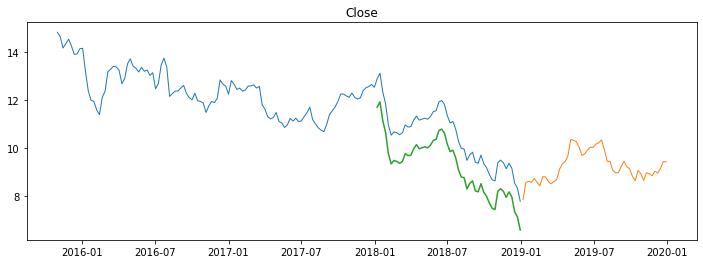

Volume -- RMSE: 17136


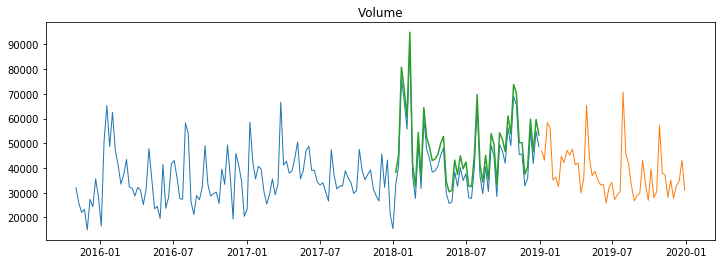

In [55]:
for col in train.columns:
    plot_and_eval(target_var = col)
    eval_df = append_eval_df(model_type = "previous_year", 
                            target_var = col)

### What model did best?

In [56]:
close_min_rmse = eval_df.groupby('target_var')['rmse'].min()[0]

volume_min_rmse = eval_df.groupby('target_var')['rmse'].min()[1]

# find which model that is
eval_df[((eval_df.rmse == close_min_rmse) | 
         (eval_df.rmse == volume_min_rmse))]

,model_type,target_var,rmse
5,4W_moving_avg,Volume,10934.0
9,4W moving average,Volume,10934.0
20,previous_year,Close,1.0


### Time to test it

In [60]:
period = 4

close = round(train['Close'].rolling(period).mean()[-1], 2)
close

8.45

In [61]:
volume = round(train['Volume'].rolling(period).mean()[-1], 2)
volume

50106.84

In [62]:
yhat_df = make_predictions()
yhat_df.head()

,Close,Volume
Date,,
2019-01-06,8.45,50106.84
2019-01-13,8.45,50106.84
2019-01-20,8.45,50106.84
2019-01-27,8.45,50106.84
2019-02-03,8.45,50106.84


In [63]:
def final_plot(target_var):
    plt.figure(figsize=(12,4))
    plt.plot(train[target_var], label='train')
    plt.plot(validate[target_var], label='validate')
    plt.plot(test[target_var], label='test')
    plt.plot(yhat_df[target_var], alpha=.5)
    plt.title(target_var)
    plt.show()

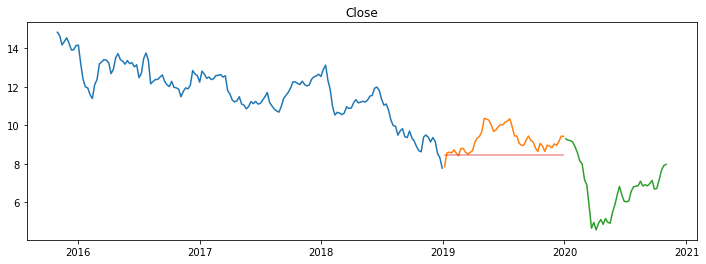

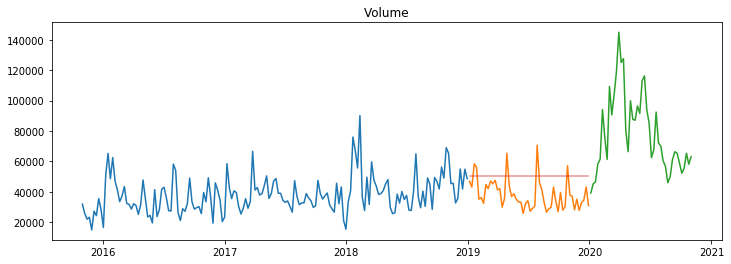

In [64]:
for col in train.columns:
    final_plot(col)
